Датасет по транзакциям карт в Европе.  
Часть этих транзакций совершена в целях мошеннических действий.  

Признаки V1, V2, … V28 являются основными компонентами, полученными с помощью PCA, единственные признаки, которые не были преобразованы с помощью PCA, — это «Time» и «Amount».  

«Time» содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных.  
«Amount» — это сумма транзакции.   

«Class» — это переменная ответа, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

Стоит цель выявить те действия которые являются мошенническими. 

Для этого будем действовать в следующем порядке: 
1. Загрзка Библиотек и данных 
2. Предварительный анализ 
3. Основной анализ EDA
4. Предобработка данных
5. Модели
6. Оценка  


### 1. Загружаем библиотеки и данные

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
# %matplotlib inline

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVC as SVM
from sklearn.svm import OneClassSVM 

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

!pip install imblearn
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

import dask.dataframe as dd
import dask.array as da


In [2]:
df = pd.read_csv('creditcard.csv')   #подгружаем в пандас
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2. Предварительный анализ 

#### Проверяем пропуски и уменьшаем объем памяти таблицы

In [3]:
df.shape, df.info() # размер, и тип данных (пропусков нет)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

((284807, 31), None)

In [4]:
# изменяем на float 32
col_to_f32 = np.delete(np.array(df.columns), [30])
col_to_f32
df[col_to_f32] = df[col_to_f32].astype('float32')
df.info()
# Размер используемой памяти уменшится в 2 раз для ускорения алгоритмов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

#### Проверяем и удаляем дубликаты

In [5]:
df[df.duplicated()] # есть дубликаты на общем фоне их не много

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.140000,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.770000,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.180000,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.180000,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.180000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282987,171288.0,1.912549,-0.455240,-1.750654,0.454324,2.089130,4.160019,-0.881302,1.081750,1.022928,...,-0.524067,-1.337510,0.473943,0.616683,-0.283548,-1.084843,0.073133,-0.036020,11.990000,0
283483,171627.0,-1.464381,1.368119,0.815992,-0.601282,-0.689115,-0.487154,-0.303778,0.884953,0.054065,...,0.287217,0.947825,-0.218773,0.082926,0.044127,0.639270,0.213565,0.119251,6.820000,0
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,...,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.930000,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.660000,0


In [6]:
# удаляем дубликаты - они могут привести к утечки данных в таргет
df.drop_duplicates(keep='first',inplace=True)
df.shape, df.info() 
print(f"Количество дубликатов: {df.duplicated().sum()}")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float32
 1   V1      283726 non-null  float32
 2   V2      283726 non-null  float32
 3   V3      283726 non-null  float32
 4   V4      283726 non-null  float32
 5   V5      283726 non-null  float32
 6   V6      283726 non-null  float32
 7   V7      283726 non-null  float32
 8   V8      283726 non-null  float32
 9   V9      283726 non-null  float32
 10  V10     283726 non-null  float32
 11  V11     283726 non-null  float32
 12  V12     283726 non-null  float32
 13  V13     283726 non-null  float32
 14  V14     283726 non-null  float32
 15  V15     283726 non-null  float32
 16  V16     283726 non-null  float32
 17  V17     283726 non-null  float32
 18  V18     283726 non-null  float32
 19  V19     283726 non-null  float32
 20  V20     283726 non-null  float32
 21  V21     28

In [7]:
# Баланс кассов

print(f'{(df['Class'].value_counts()[1] / df['Class'].value_counts()[0])*100} % действий являются мошеническими')
df['Class'].value_counts() 

0.16698852262818045 % действий являются мошеническими


0    283253
1       473
Name: Class, dtype: int64

In [8]:
df.describe().T # основные статистики

,count,mean,std,min,25%,50%,75%,max
Time,283726.0,94809.679688,47480.457031,0.000000,54204.750000,84692.500000,139298.000000,172792.000000
V1,283726.0,0.005917,1.947952,-56.407509,-0.915951,0.020384,1.316068,2.454930
V2,283726.0,-0.004135,1.646582,-72.715729,-0.600321,0.063949,0.800283,22.057730
V3,283726.0,0.001615,1.508639,-48.325588,-0.889682,0.179963,1.026960,9.382559
V4,283726.0,-0.002965,1.414147,-5.683171,-0.850134,-0.022248,0.739647,16.875343
V5,283726.0,0.001827,1.376946,-113.743309,-0.689830,-0.053468,0.612218,34.801666
V6,283726.0,-0.001140,1.331881,-26.160505,-0.769031,-0.275168,0.396792,73.301628
V7,283726.0,0.001801,1.227602,-43.557243,-0.552509,0.040859,0.570474,120.589493
V8,283726.0,-0.000855,1.178902,-73.216721,-0.208828,0.021898,0.325704,20.007208
V9,283726.0,-0.001596,1.095429,-13.434067,-0.644221,-0.052596,0.595977,15.594995


### 3. EDA

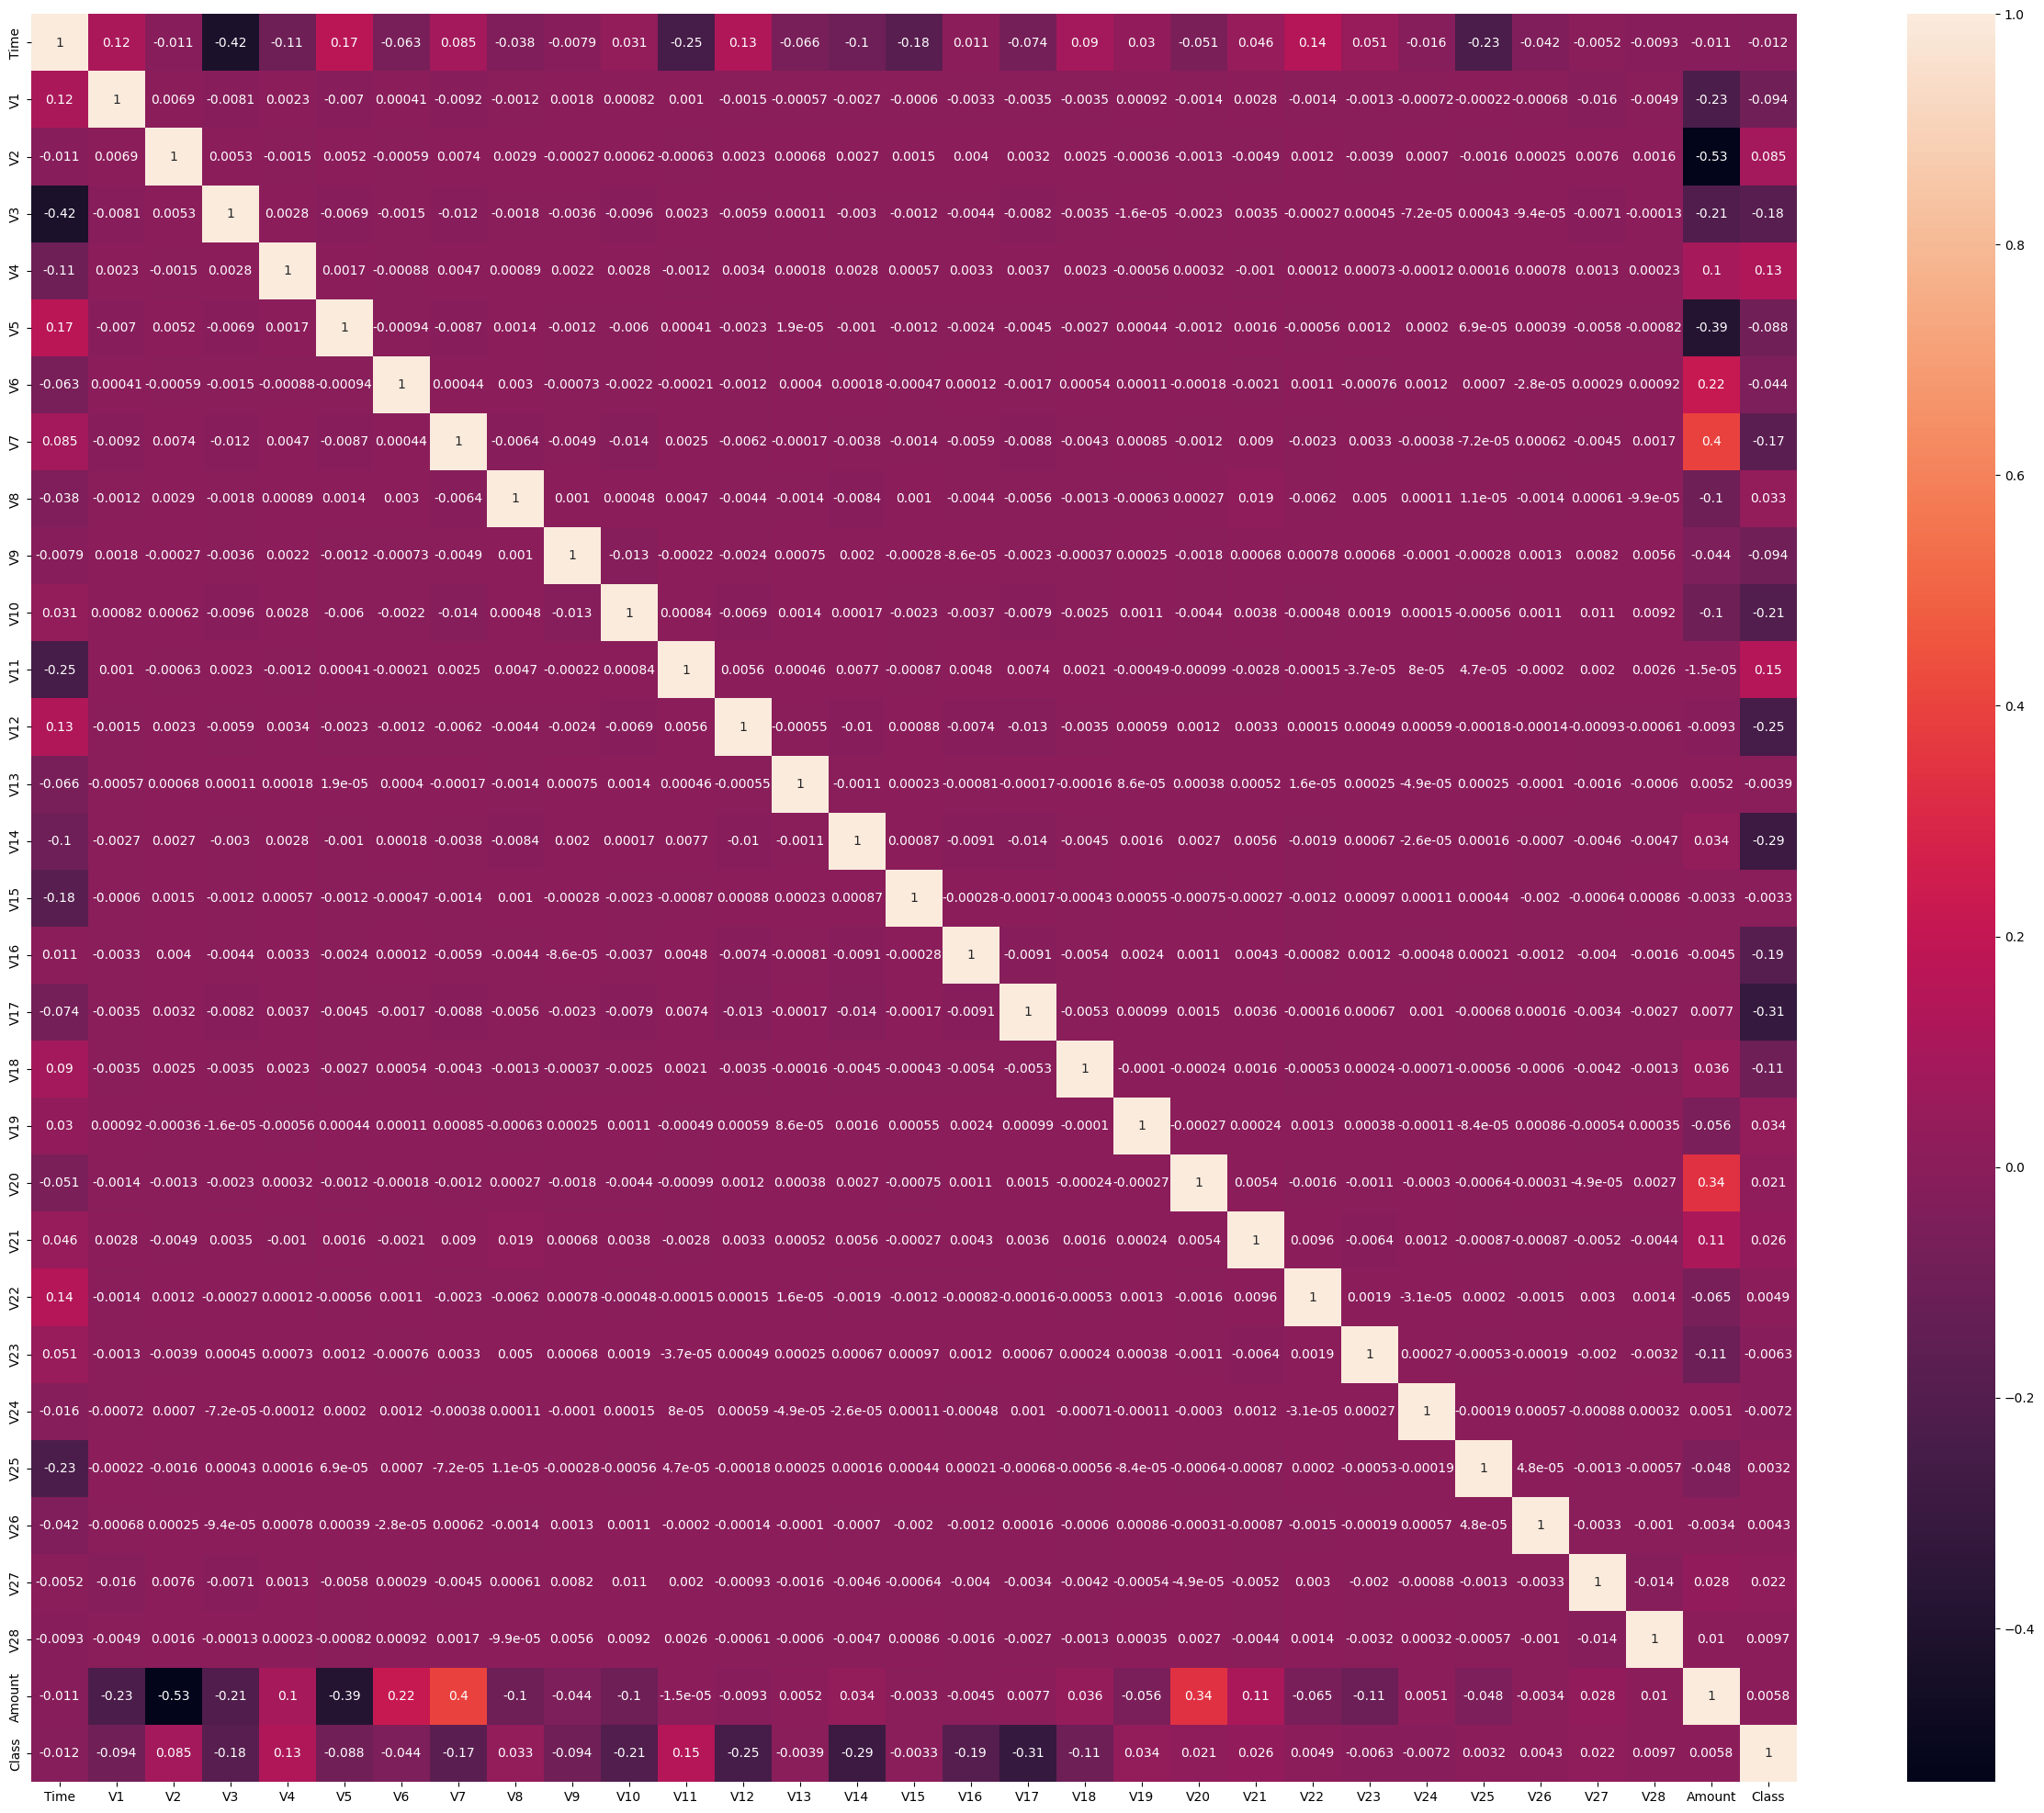

In [9]:
plt.figure(figsize=(31,25)) # матрица корреляций
sns.heatmap(df.corr(), annot=True);

Корреляция с целевым признаком плохая:  
есть небольшая обратная корреляция с целевым признаком 'Class' у 'V10', 'V12', 'V14', 'V17'


По корреляции с 'Amount':  
неплохая положительная коррелиция с - 'V7' и 'V20'  
неплохая отрицательная коррелиция с - 'V2' и 'V5'  

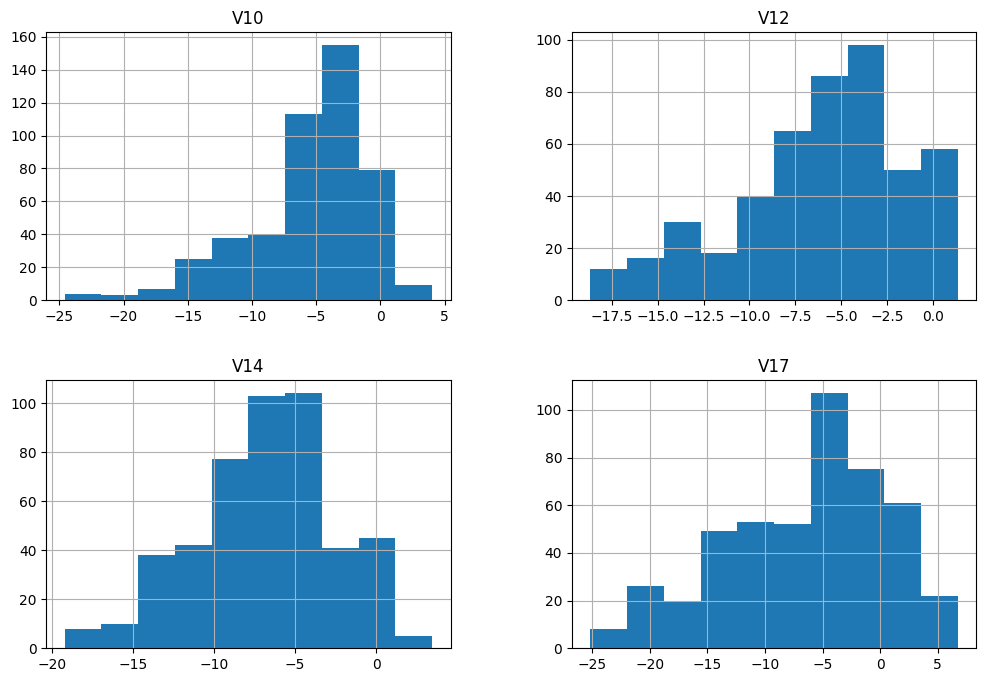

In [10]:
columns_cor = ['V10', 'V12', 'V14', 'V17'] # гистограммы коррелирующих признаков
mask_corcol = df['Class'].apply(lambda x: x != 0)
df[columns_cor][mask_corcol].hist(figsize = (12,8));

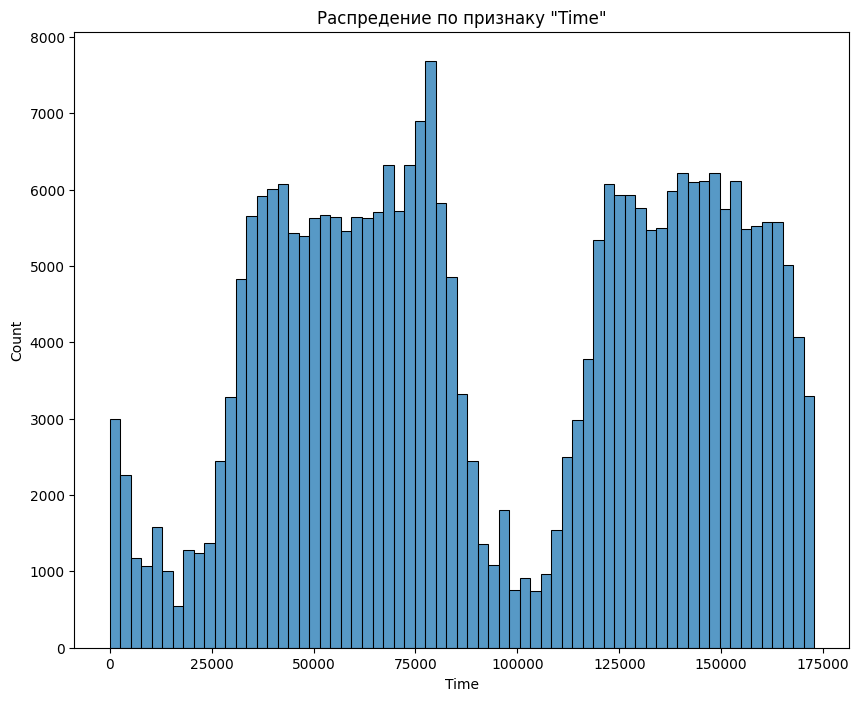

In [11]:
plt.figure(figsize=(10,8))
plt.title('Распредение по признаку "Time"')
sns.histplot(df['Time']);

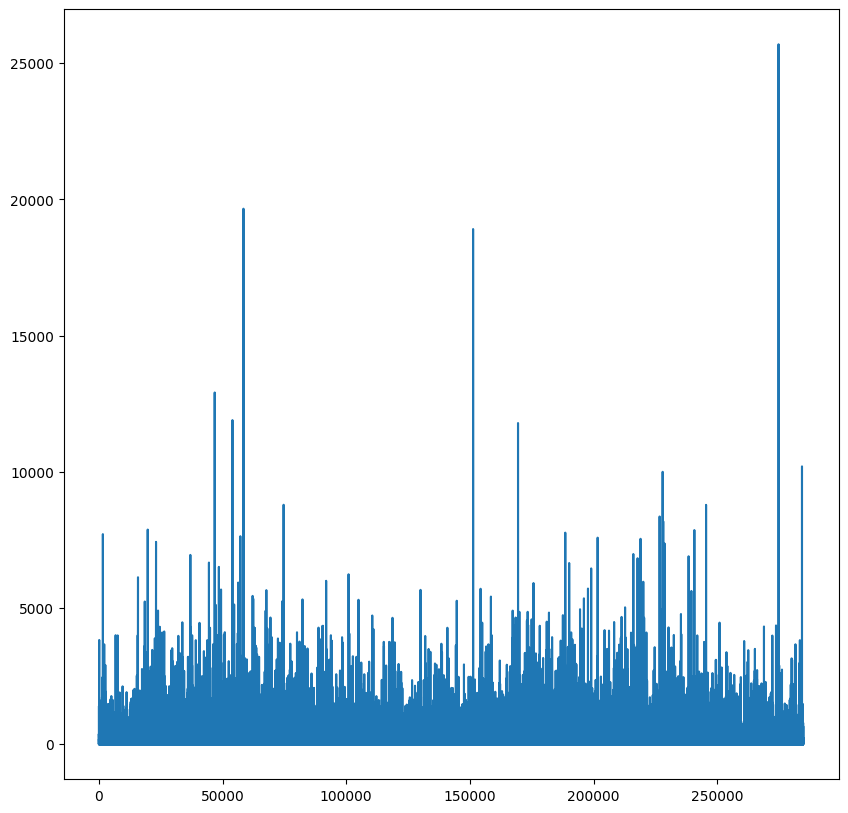

In [12]:
df['Amount'].plot(figsize = (10, 10)); 

Визуально видно что есть что-то похожее на выбросы, построим ящик с усами чтобы удостовериться. 

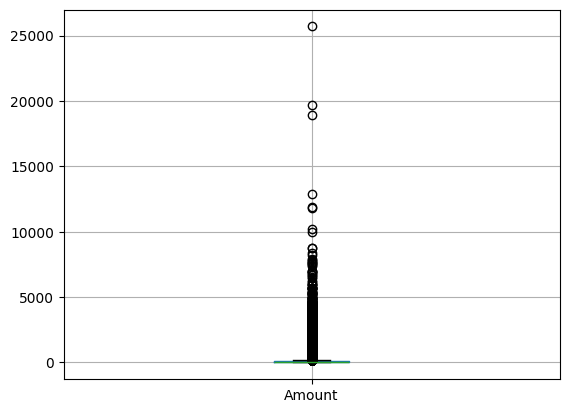

In [13]:
df.boxplot(column = 'Amount');

Попробуем убрать выбросы

In [14]:
lower_line = df['Amount'].median()-1.5*(df['Amount'].quantile(0.75) - df['Amount'].quantile(0.25))
upper_line = df['Amount'].median()+1.5*(df['Amount'].quantile(0.75) - df['Amount'].quantile(0.25))
print(lower_line, upper_line) # верхние и нижние границы чтобы убрать выбросы

-85.86500334739685 129.86500334739685


In [15]:
df_new = df[(df['Amount'] < upper_line )& (df['Amount'] > lower_line )]
df_new.shape, df.shape # убираем выбросы, смотрим размер

((238144, 31), (283726, 31))

In [16]:
print(df_new['Class'].value_counts())
print(df['Class'].value_counts())


0    237772
1       372
Name: Class, dtype: int64
0    283253
1       473
Name: Class, dtype: int64


Далее будем работать с полноценным датасетом потому что при удалении выбросов теряем около 20% из целевой переменной(а она у нас и так меньше процента от всего объема данных)

### 4. Предобработка данных 

In [17]:
df_n = df.copy() 
X = np.array(df_n.drop(['Class'],axis=1)) # создаем Х (без целевого)
y = np.array(df_n['Class']) # создаем у (целевой)
# нормируем датасет  
X_ss = StandardScaler().fit(X).transform(X)  
X_tr, X_ts, y_tr, y_ts = train_test_split(X_ss, y, test_size=0.2, stratify=y, random_state=90)
print(X_tr.shape, y_tr.shape )
print(X_ts.shape, y_ts.shape )

(226980, 30) (226980,)
(56746, 30) (56746,)


ADASIN - аугментация

In [18]:
#### смотрим баланс классов
X_tr_a, y_tr_a = ADASYN().fit_resample(X_tr, y_tr)
print(X_tr_a.shape, y_tr_a.shape)
pd.Series(y_tr_a).value_counts()  

(453180, 30) (453180,)


0    226602
1    226578
dtype: int64

Smote - аугментация

In [19]:
####  смотрим баланс классов
X_tr_s, y_tr_s = SMOTE().fit_resample(X_tr, y_tr)
print(X_tr_s.shape, y_tr_s.shape)
pd.Series(y_tr_s).value_counts()  

(453204, 30) (453204,)


0    226602
1    226602
dtype: int64

In [36]:
for_df = []

### 5. Модели

In [38]:
from sklearn import metrics
def save_score(name, alg,  tr_x, tr_y, ts_x, ts_y):
    alg.fit(tr_x, tr_y)
    fpr, tpr, _ =  metrics.roc_curve(ts_y,alg.predict(ts_x)) 
    result = [
        name, 
        metrics.mean_squared_error(ts_y,alg.predict(ts_x)),
        metrics.r2_score(ts_y, alg.predict(ts_x)),
        metrics.auc(fpr,tpr)    ]
    print(result)
    return result

In [39]:
for_df.append(save_score("lr", LinearRegression(),X_tr, y_tr, X_ts, y_ts  ))

['lr', 0.0009256775589222055, 0.4461411237716675, 0.9867296438303221]


In [40]:
for_df.append(save_score("lr_a", LinearRegression(),X_tr_a, y_tr_a, X_ts, y_ts  ))

['lr_a', 0.1066961938814572, -62.83932876586914, 0.9638586767177427]


In [41]:
for_df.append(save_score("lr_s", LinearRegression(),X_tr_s, y_tr_s, X_ts, y_ts  ))

['lr_s', 0.055498801137575285, -32.206485748291016, 0.9654137196444713]


### 6. Оценка

In [42]:
pd.DataFrame(for_df, 
             columns=['name_alg', 'MSE', 'R2', 'AUC'])

,name_alg,MSE,R2,AUC
0,lr,0.000926,0.446141,0.986730
1,lr_a,0.106696,-62.839329,0.963859
2,lr_s,0.055499,-32.206486,0.965414


Проводить оценку моделей с используемыми данными не совсем коректно, но в данном случае аугментация нам не оказал никакого положительного влияния.  
В данном случае по метрикам модель линейной регрессии с неаугментированными данными показала себя лучше остальных.  
Далее для сравнения построим еще несколько моделей.


### 7. Дополнительные модели

#### 7.1 Log_r

In [43]:
log_r = LogisticRegression(C=1)
for_df.append(save_score("log_r", log_r, X_tr, y_tr, X_ts, y_ts  ))


['log_r', 0.0010044760864201883, 0.39899383947326594, 0.7788149788780613]


#### 7.2 SVM


In [44]:
svm = SVM()
for_df.append(save_score("SVM", svm, X_tr, y_tr, X_ts, y_ts  ))


['SVM', 0.0005815387868748458, 0.6520490649582067, 0.8420787852492965]


#### 7.3 ElasticNet

In [45]:
en = ElasticNet()
for_df.append(save_score("ElasticNet", en, X_tr, y_tr, X_ts, y_ts  ))


['ElasticNet', 0.0016713241872434816, -3.5762786865234375e-07, 0.5]


In [46]:
pd.DataFrame(for_df, 
             columns=['name_alg', 'MSE', 'R2', 'AUC'])

,name_alg,MSE,R2,AUC
0,lr,0.000926,4.461411e-01,0.986730
1,lr_a,0.106696,-6.283933e+01,0.963859
2,lr_s,0.055499,-3.220649e+01,0.965414
3,log_r,0.001004,3.989938e-01,0.778815
4,SVM,0.000582,6.520491e-01,0.842079
5,ElasticNet,0.001671,-3.576279e-07,0.500000
